<a href="https://colab.research.google.com/github/bforoura/GENAI26/blob/main/Module4/Vector_Stores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# We need the Google-specific LangChain integration and a vector store (Chroma)
# pypdf is capable of splitting, merging, cropping, and transforming the pages of PDF files


!pip install -qU pypdf langchain-google-genai langchain-community langchain-text-splitters chromadb langchain-core langchain-chroma

In [40]:
# The API KEY and imported libraries
import os
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')


from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser



# **Basic Embeddings Usage**

In [41]:
import os
from langchain_google_genai import GoogleGenerativeAIEmbeddings

# Initialize the embeddings model
embeddings_model = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")

# Example sentences
text1 = "The cat sat on the mat"
text2 = "A feline rested on the carpet"
text3 = "Python is a programming language"

# Get embeddings using LangChain
embeddings = embeddings_model.embed_documents([text1, text2, text3])

# Extract individual vectors
embedding1 = embeddings[0]  # Embedding for "The cat sat on the mat"
embedding2 = embeddings[1]  # Embedding for "A feline rested on the carpet"
embedding3 = embeddings[2]  # Embedding for "Python is a programming language"

# Output results
print(f"Number of documents: {len(embeddings)}")
print(f"Dimensions per embedding: {len(embeddings[0])}")




Number of documents: 3
Dimensions per embedding: 3072


# **Vector Store Setup**

* This code performs a complete workflow for **Semantic Search** and **Retrieval** using Google's Gemini AI and the** Chroma vector database**.

* It shows how the AI **understands** meaning rather than just matching keywords.

* This model produces a **vector** with **3,072 dimensions**, which allows for a high level of detail in understanding the meaning of the text.

* We create three simple text objects. Notice the **metadata** is like a "**tag**" we attach to each document so we can keep track of them by ID

* **add_documents**  reads the text, turns it into numbers, and Chroma saves them for fast searching.

* **similarity_search** looks for the top 2 documents that are mathematically closest to the query. It only cares about relevance. If the two best matches are almost identical, it will return both, even if they are redundant.

* **MMR (Max Marginal Relevance)** finds documents that are relevant to the query but different from each other

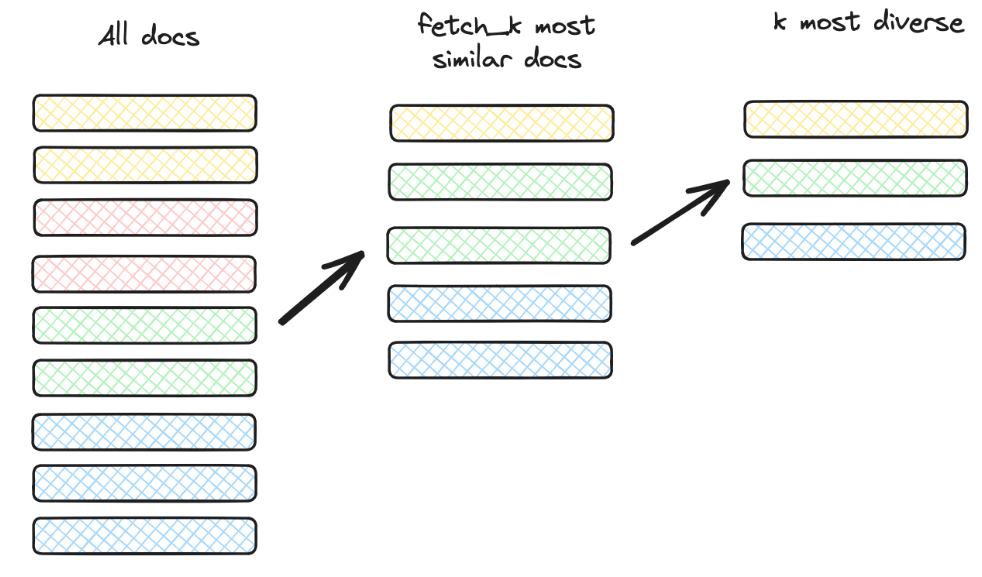

* **lambda_mult** is the **Diversity Slider**:
   * 1.0 --> Only cares about relevance, acts like a normal search.
   * 0.0 --> Only cares about diversity, will give you very different topics.
   * 0.5 --> A perfect balance, it finds a document that answers your question but ensures it's not just a duplicate of something it already found.

In [43]:
import os
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_chroma import Chroma
from langchain_core.documents import Document

# Initialize Gemini Embeddings
# The model "models/gemini-embedding-001" is the standard for Gemini vectors
embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")



# Create sample documents
docs = [
    Document(page_content="Content about language models", metadata={"id": "doc_1"}),
    Document(page_content="Information about vector databases", metadata={"id": "doc_2"}),
    Document(page_content="Details about retrieval systems", metadata={"id": "doc_3"})
]



# Create the vector store
# Using the newer 'langchain_chroma' package
vector_store = Chroma(embedding_function=embeddings)



# Add documents with explicit IDs
vector_store.add_documents(docs)




# Similarity Search
results = vector_store.similarity_search("How do language models work?", k=2)




# MMR (Max Marginal Relevance) logic
found_docs = vector_store.similarity_search("retrieval", k=1)
print(f"Found documents: {len(found_docs)}")

used_doc_ids = {doc.metadata["id"] for doc in found_docs}
remaining_docs = [doc for doc in docs if doc.metadata["id"] not in used_doc_ids]
print(f"Remaining documents available for MMR: {len(remaining_docs)}")

if len(remaining_docs) > 0:
    # MMR focuses on finding documents that are relevant but also different
    # from what was already found, to avoid repetitive answers.
    mmr_results = vector_store.max_marginal_relevance_search(
        "retrieval systems",
        k=1,
        fetch_k=3, # fetch_k should generally be >= k
        lambda_mult=0.0
    )
    print(f"MMR Result: {mmr_results[0].page_content}")



Found documents: 1
Remaining documents available for MMR: 2
MMR Result: Details about retrieval systems


## **Explanation of Above Results**


* The system looked through the 3 documents and found the single best match for the word "**retrieval**".

* Based on the sample data, this was "**Details about retrieval systems" (doc_3)**.

* **MMR** tries to find a document that is both relevant to the query and different from documents already selected.

* See what happens if you change the lambda_mult to 0.0 to force the AI to ignore relevance and pick the most "random" or "diverse" document instead.


# **The Global Warming Knowledge Base**

* To handle multiple queries and display exactly what the AI found, we can use a loop to iterate through a list of questions.

* We can also add a helper function to print the page_content and metadata for each result so we can see the matching document IDs.

In [55]:
import os
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_chroma import Chroma
from langchain_core.documents import Document

# Initialize Embeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")



# Climate Science Knowledge Base Documents
docs = [
    Document(
        page_content="""The Greenhouse Effect: Atmospheric CO2 concentrations have
        surpassed 420 parts per million (ppm). These molecules trap long-wave
        infrared radiation that would otherwise escape into space, leading to
        a positive radiative forcing and a steady increase in the global
        mean surface temperature (GMST).""",
        metadata={"id": "climate_physics", "topic": "science", "region": "global"}
    ),
    Document(
        page_content="""Economic Impact of Sea Level Rise: Coastal cities like
        Jakarta, Miami, and Amsterdam face multi-billion dollar infrastructure
        risks. Rising sea levels, driven by thermal expansion and glacial melt,
        are projected to displace over 150 million people by 2050, leading to
        significant migration-related economic shifts and insurance market volatility.""",
        metadata={"id": "econ_impact", "topic": "economics", "region": "coastal"}
    ),
    Document(
        page_content="""Reforestation and Carbon Sequestration: Natural climate
        solutions, such as restoring the Amazon rainforest and expanding boreal
        forests, can provide up to 30% of the mitigation needed to limit warming
        to 1.5°C. Trees act as 'carbon sinks,' biologically capturing atmospheric
        carbon and storing it in biomass and soil.""",
        metadata={"id": "nature_mitigation", "topic": "mitigation", "region": "forests"}
    ),
    Document(
        page_content="""The Paris Agreement Framework: This international treaty
        aims to limit global warming to well below 2°C, preferably 1.5°C,
        compared to pre-industrial levels. It requires countries to submit
        Nationally Determined Contributions (NDCs) that outline their specific
        targets for reducing greenhouse gas emissions every five years.""",
        metadata={"id": "policy_framework", "topic": "policy", "region": "international"}
    )
]



# Create the vector store
vector_store = Chroma(embedding_function=embeddings)
vector_store.add_documents(docs)



# Multi-Query Analysis
queries = [
    "How does carbon dioxide affect the planet and what are the laws about it?",
    "Explain the solutions to climate change across different sectors.",
    "What is the best way to bake a chocolate sourdough bread?" # Non-related
]

def display_results(results, query, search_type):
    print(f"\n[{search_type}] Search | Query: '{query}'")
    for i, doc in enumerate(results):
        topic_info = doc.metadata.get('topic', 'N/A')  # Safely get 'topic' or default to 'N/A'
        print(f"  {i+1}. ID: {doc.metadata.get('id', 'N/A')} | Topic: {topic_info}")
        print(f"     Content: {doc.page_content[:140]}...")




# Execute search
for q in queries:
    # Similarity Search: Best matches for the specific keywords
    sim_results = vector_store.similarity_search(q, k=2)
    display_results(sim_results, q, "SIMILARITY")

    # MMR Search: Finds a broader, more diverse overview
    # lambda_mult=0.3 is quite low, prioritizing "new information" over "best match"
    mmr_results = vector_store.max_marginal_relevance_search(q, k=2, fetch_k=4, lambda_mult=0.3)
    display_results(mmr_results, q, "MMR")


[SIMILARITY] Search | Query: 'How does carbon dioxide affect the planet and what are the laws about it?'
  1. ID: climate_physics | Topic: science
     Content: The Greenhouse Effect: Atmospheric CO2 concentrations have 
        surpassed 420 parts per million (ppm). These molecules trap long-wave 
 ...
  2. ID: climate_physics | Topic: science
     Content: The Greenhouse Effect: Atmospheric CO2 concentrations have 
        surpassed 420 parts per million (ppm). These molecules trap long-wave 
 ...

[MMR] Search | Query: 'How does carbon dioxide affect the planet and what are the laws about it?'
  1. ID: climate_physics | Topic: science
     Content: The Greenhouse Effect: Atmospheric CO2 concentrations have 
        surpassed 420 parts per million (ppm). These molecules trap long-wave 
 ...
  2. ID: climate_physics | Topic: science
     Content: The Greenhouse Effect: Atmospheric CO2 concentrations have 
        surpassed 420 parts per million (ppm). These molecules trap long-wave 


# **Diagram Generated by Nano Banana**

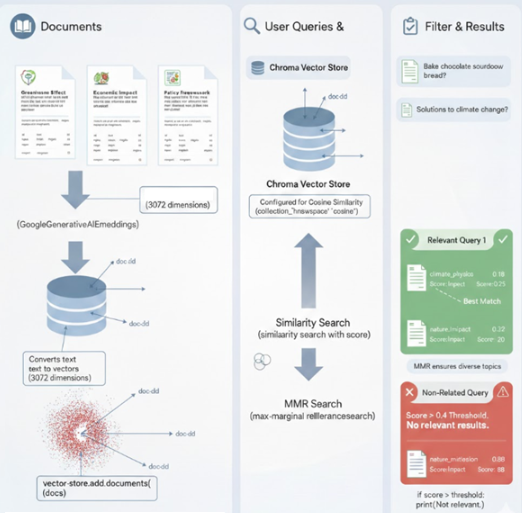